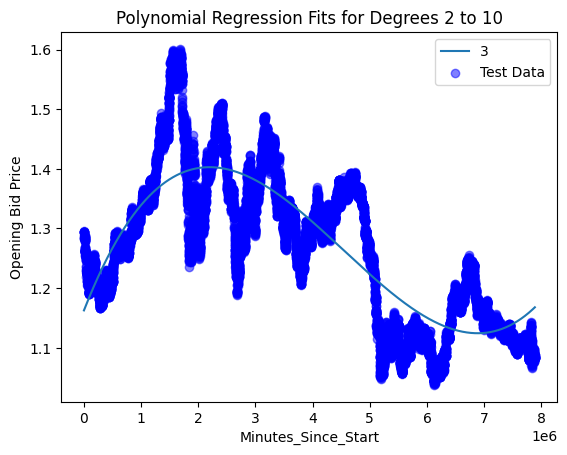

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('eurusd_hour.csv')

# Rename columns to more descriptive names
df.rename(columns={
    'BO': 'Opening bid price',
    'BH': 'Highest bid price',
    'BL': 'Lowest bid price',
    'BC': 'Closing bid price',
    'BCh': 'Change between bid open and close price',
    'AO': 'Opening ask price',
    'AH': 'Highest ask price',
    'AL': 'Lowest ask price',
    'AC': 'Closing ask price',
    'ACh': 'Change between ask open and close price'
}, inplace=True)

# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the datetime column to a numeric format (e.g., timestamp)
df['Timestamp'] = df['Datetime'].astype('int64') // 10**9  # Convert to seconds since epoch

# Alternatively, you could calculate the minutes since the start of the data
df['Minutes_Since_Start'] = (df['Datetime'] - df['Datetime'].min()).dt.total_seconds() / 60

# Drop the original Date and Time columns
df = df.drop(columns=['Date', 'Time', 'Datetime'])

# Feature selection
x1 = df[['Minutes_Since_Start']]
y1 = df[['Opening bid price']]

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# Create a plot with multiple polynomial degrees

    # Create polynomial features
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

    # Fit the model
model = LinearRegression()
model.fit(x_train_poly, y_train)

    # Predict using the model on the test data
y_test_pred = model.predict(x_test_poly)

    # Sort the test values for better visualization
sort_axis = np.argsort(x_test['Minutes_Since_Start'].values)
x_test_sorted = x_test['Minutes_Since_Start'].values[sort_axis]
y_test_pred_sorted = y_test_pred[sort_axis]

    # Plot the polynomial fit
plt.plot(x_test_sorted, y_test_pred_sorted, label= 3)

# Plot the actual test data
plt.scatter(x_test, y_test, color='blue', label='Test Data', alpha=0.5)

# Plot settings
plt.xlabel('Minutes_Since_Start')
plt.ylabel('Opening Bid Price')
plt.title('Polynomial Regression Fits for Degrees 2 to 10')
plt.legend()
plt.show()
